#Proyecto Deep Learning

Este proyecto tiene como objetivo desarrollar una red neuronal convolucional (CNN) para identificar emociones humanas a partir de imágenes. El entrenamiento de la red se realizará utilizando un dataset que contiene seis emociones distintas: Feliz, Enojado, Triste, Neutral, Sorpresa y Ahegao. Las imágenes del dataset son de tipo RGB y presentan rostros recortados con las emociones correspondientes.

###Descripción del Dataset
El dataset se recopiló mediante scraping de redes sociales como Facebook e Instagram, la extracción de videos de YouTube y el uso de datasets ya disponibles, como IMDB y AffectNet. La estructura del dataset es la siguiente:

dataset.zip: Contiene carpetas con imágenes correspondientes a cada clase de emoción.

data.csv: Contiene las rutas a las imágenes y las etiquetas correspondientes.

Este modelo tiene aplicaciones potenciales en áreas como la atención al cliente, los sistemas de entretenimiento y la investigación psicológica.

#IMPORTANTE
Hay que tener en cuenta que este dataset incluye la clase de ahegao, que si bien, no considero que sea lo mas apropiado, al momento de obtener los resultados fue la clase con mejores metricas, esto me ayudo a dar ciertas conclusiones respecto al modelo que sin esa clse no hubiera obtenido, yu que explicare mas adelante


#Modelo Usado

###Importación de Librerías
Primero, se importan las librerías necesarias para el proyecto.

In [125]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

###Cargar el Archivo CSV
Se carga el archivo CSV que contiene las rutas a las imágenes y las etiquetas correspondientes.

In [126]:
# Cargar el archivo CSV
dataset = pd.read_csv('/kaggle/input/emotion-recognition-dataset/data.csv')

# Verifica que el archivo se haya cargado correctamente
print(dataset.head())

   Unnamed: 0                                               path     label
0           0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1           1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2           2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3           3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4           4       Surprise/cropped_emotions.263616~12fffff.png  Surprise


###Definir Función para Preprocesar Imágenes
Se define una función para cargar y preprocesar las imágenes (redimensionarlas y normalizarlas).

In [127]:
def load_and_preprocess_image(path, target_size=(64, 64)):
    path = "dataset/" + path
    img = load_img(path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalizar al rango [0,1]
    return img_array

###Convertir Etiquetas a Categorías
Se convierten las etiquetas de texto a categorías numéricas y luego a formato one-hot encoding.

In [137]:

# Convertir etiquetas a categorías
sentimientos = dataset['label'].astype('category').cat.codes
labels = to_categorical(sentimientos)

# Convertir las etiquetas a categorías y obtener las clases
clases = dataset['label'].astype('category').cat.categories
clases_dict = dict(enumerate(clases))

###Cargar y Preprocesar las Imágenes
Se cargan y preprocesan las imágenes del dataset. Las imágenes se guardan en un archivo numpy para evitar preprocesarlas cada vez que se corre el código.

Al ser poco practico el procesar las imagenes cada que se quiera entrenar el modelo, se utiliza el archivo que se genera sin necesidad de volver a procesar los datos

In [129]:
# Cargar y preprocesar las imágenes
# images = np.array([load_and_preprocess_image(path) for path in dataset['path']])
# np.save('imagenes_procesadas.npy', images)

images = np.load('/kaggle/input/imagenes/imagenes_procesadas128.npy')
labels = np.array(labels)

###Dividir Datos en Entrenamiento y Validación
Se dividen los datos en conjuntos de entrenamiento y validación.

In [130]:
# Dividir en datos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

###Configuración de Data Augmentation
Se configura la augmentación de datos para el conjunto de entrenamiento.

In [131]:
# Configuración de Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalización de las imágenes
    rotation_range=30,  # Rotación aleatoria de hasta 30 grados
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    shear_range=0.2,  # Cizallamiento
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal aleatorio
    fill_mode='nearest'  # Rellenar los píxeles faltantes
)

# El generador para validación no necesita augmentación, solo normalización
val_datagen = ImageDataGenerator(rescale=1.0/255)

###Crear Generadores de Datos
Se crean los generadores de datos para el entrenamiento y la validación.

In [132]:
# Fit el generador de datos de entrenamiento
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
val_generator = val_datagen.flow(x_val, y_val, batch_size=64)

###Definir y Compilar el Modelo
Se define la arquitectura de la red neuronal y se compila el modelo.

Modelo Secuencial: Utiliza una pila de capas donde cada capa está conectada directamente a la siguiente.

Capa de Entrada: Define el tamaño de las imágenes de entrada (64x64 píxeles con 3 canales de color).

Capas Convolucionales (Conv2D): Estas capas extraen características de las imágenes usando filtros (también conocidos como kernels) y aplican la función de activación ReLU para añadir no linealidad.

Capas de Pooling (MaxPooling2D): Reducen la dimensión espacial de las imágenes para disminuir la cantidad de parámetros y el costo computacional.

Capas de Dropout: Apagan aleatoriamente una fracción de las unidades de salida durante el entrenamiento para prevenir el sobreajuste.

Capa de Flatten: Aplana la salida de las capas anteriores en un vector unidimensional, preparando los datos para las capas densas.

Capas Densas (Dense): Estas son capas totalmente conectadas que realizan la clasificación final de las imágenes.

Capa de Salida: Utiliza la activación softmax para generar probabilidades de pertenencia a cada una de las clases.

Compilación del Modelo: Se define el optimizador, la función de pérdida y las métricas de rendimiento. El optimizador Adam es utilizado para ajustar los pesos del modelo, y la pérdida de entropía cruzada categórica es adecuada para problemas de clasificación multi-clase.

Este proceso crea un modelo de red neuronal convolucional (CNN) que está preparado para clasificar imágenes en distintas categorías, aplicando diversas técnicas de procesamiento para mejorar su capacidad de aprendizaje y su rendimiento.

In [133]:
model = Sequential([
    Input(shape=(128, 128, 3)),  # Capa de entrada explícita
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.7),
    Dense(labels.shape[1], activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

###Configurar EarlyStopping
Se configura el callback de EarlyStopping para detener el entrenamiento si no hay mejoras despues de 5 epochs.

In [134]:
# Configurar el EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitorea la pérdida en los datos de validación
                               patience=5,          # Número de épocas sin mejora antes de detener el entrenamiento
                               verbose=1,           # Muestra información sobre el early stopping
                               restore_best_weights=True)  # Restaura los pesos del modelo cuando se detiene

###Entrenar el Modelo
Se entrena el modelo utilizando los datos de entrenamiento y se valida con los datos de validación. Se utilizan batch de 64 imagenes y se recorren hasta 100 epochs si es que hay una mejora continua

In [135]:
# Entrenar el modelo con EarlyStopping
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.2481 - loss: 1.7343 - val_accuracy: 0.2759 - val_loss: 1.5791
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2793 - loss: 1.6072 - val_accuracy: 0.3408 - val_loss: 1.5132
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3286 - loss: 1.5236 - val_accuracy: 0.4023 - val_loss: 1.3959
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3609 - loss: 1.4803 - val_accuracy: 0.4513 - val_loss: 1.3359
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4009 - loss: 1.4127 - val_accuracy: 0.4994 - val_loss: 1.2393
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4537 - loss: 1.3122 - val_accuracy: 0.5091 - val_loss: 1.2019
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4484 - loss: 1.3290 - val_accuracy: 0.5056 - val_loss: 1.1469
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4934 - loss: 1.2165 -

###Evaluar el Modelo
Se evalúa el modelo utilizando los datos de validación.

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7448 - loss: 0.6347
Pérdida en los datos de validación: 0.65108722448349
Precisión en los datos de validación: 0.7392148375511169
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
F1 Score: 0.7386184810197854


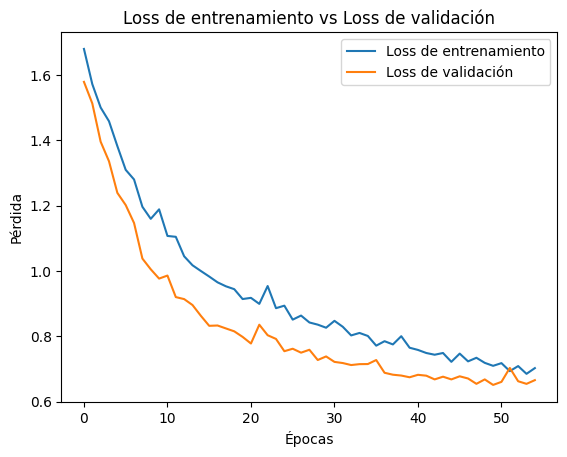

              precision    recall  f1-score   support

      Ahegao       0.91      0.92      0.91       369
       Angry       0.76      0.48      0.59       368
       Happy       0.90      0.89      0.89      1137
     Neutral       0.68      0.66      0.67      1197
         Sad       0.61      0.71      0.66      1202
    Surprise       0.74      0.71      0.72       363

    accuracy                           0.74      4636
   macro avg       0.77      0.73      0.74      4636
weighted avg       0.75      0.74      0.74      4636



In [139]:
from sklearn.metrics import classification_report

# Evaluar el modelo en los datos de validación
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Pérdida en los datos de validación: {loss}')
print(f'Precisión en los datos de validación: {accuracy}')

# Realizar predicciones sobre los datos de validación
y_pred = model.predict(x_val)

# Convertir las predicciones a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calcular el F1 score
f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')  # 'weighted' para ponderar por el tamaño de cada clase
print(f'F1 Score: {f1}')

# Graficar las pérdidas de entrenamiento y validación
plt.plot(history.history['loss'], label='Loss de entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de validación')

# Agregar etiquetas y título
plt.title('Loss de entrenamiento vs Loss de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar el gráfico
plt.show()

# Generar el reporte de clasificación
reporte = classification_report(y_val_classes, y_pred_classes, target_names=[clases_dict[i] for i in range(len(clases_dict))])

# Imprimir el reporte
print(reporte)


model.save('MejorModelo.h5')

###Análisis por Clase
Ahegao:

Precisión: 0.91

Recall: 0.92

F1-Score: 0.91

Soporte: 369

Interpretación: El modelo es muy preciso y tiene una buena cobertura para esta clase.

Angry:

Precisión: 0.76

Recall: 0.48

F1-Score: 0.59

Soporte: 368

Interpretación: La precisión es moderada, pero el recall es bastante bajo, lo que indica que el modelo está perdiendo muchos ejemplos de esta clase (falsos negativos).

Happy:

Precisión: 0.90

Recall: 0.89

F1-Score: 0.89

Soporte: 1137

Interpretación: El modelo tiene un excelente desempeño en esta clase, con altos valores de precisión y recall.

Neutral:

Precisión: 0.68

Recall: 0.66

F1-Score: 0.67

Soporte: 1197

Interpretación: El modelo tiene un desempeño moderado para esta clase, con valores de precisión y recall bastante equilibrados pero no tan altos.

Sad:

Precisión: 0.61

Recall: 0.71

F1-Score: 0.66

Soporte: 1202

Interpretación: El modelo tiene mejor recall que precisión, lo que significa que clasifica correctamente muchos ejemplos de esta clase, pero también incluye algunos falsos positivos.

Surprise:

Precisión: 0.74

Recall: 0.71

F1-Score: 0.72

Soporte: 363

Interpretación: El desempeño es bastante bueno, con un buen balance entre precisión y recall.

General: Analizando el dataset y viendo las imagenes de cada clase, se puede observar que las clases con las expresiones mas exageradas son las que obtienen mayortes resultados, sin embargo, las clases con expresiones mas parecidas, se puede notar una notoria conclusion entre dichas clases, es probables que ocn un dataset mas normalizado, y con expresiones mas exageradas entre imagenes se obtendria un mejor resultado general

#Pruebas Hechas
Se hicieron diversas pruebas para lograr el modelo final, entre lo mas destacable esta el modelo sin normalizacion ni data augmentation y el modelo con los minimos recursos, se intento hace un modelo con Hyperband, sin embargo mostro error en varias ocasiones antes de terminar de ejectuarse, aun asi mas abajo viene el codigo para dicho modelo

##Modelo Prueba 1

   Unnamed: 0                                               path     label
0           0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1           1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2           2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3           3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4           4       Surprise/cropped_emotions.263616~12fffff.png  Surprise
Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3156 - loss: 1.6161 - val_accuracy: 0.4953 - val_loss: 1.2535
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5278 - loss: 1.1976 - val_accuracy: 0.5636 - val_loss: 1.1187
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5828 - loss: 1.0537 - val_accuracy: 0.5729 - val_loss: 1.0722
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6341 - loss: 0.9281 - val_accuracy: 0.5938 - val_loss: 1.0207
Epoch 5/100
170/170 ━━━━━━━━━━━━━

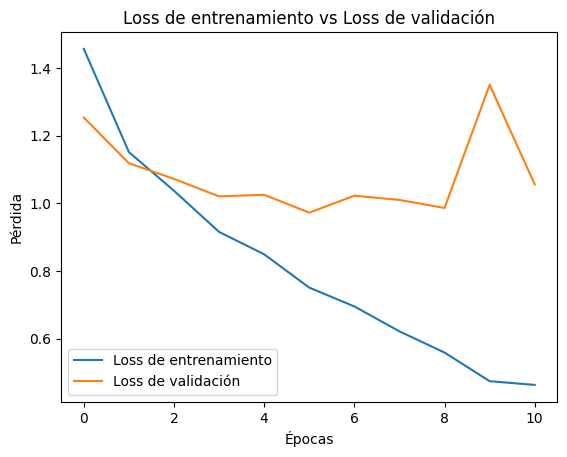

In [98]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Cargar el archivo CSV
dataset = pd.read_csv('/kaggle/input/emotion-recognition-dataset/data.csv')

# Verifica que el archivo se haya cargado correctamente
print(dataset.head())

# Convertir etiquetas a categorías
sentimientos = dataset['label'].astype('category').cat.codes
labels = to_categorical(sentimientos)

images = np.load('/kaggle/input/imagenes/imagenes_procesadas64.npy')
labels = np.array(labels)

# Dividir en datos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

model = Sequential([
    Input(shape=(64, 64, 3)),  # Capa de entrada explícita
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(labels.shape[1], activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar el EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitorea la pérdida en los datos de validación
                               patience=5,          # Número de épocas sin mejora antes de detener el entrenamiento
                               verbose=1,           # Muestra información sobre el early stopping
                               restore_best_weights=True)  # Restaura los pesos del modelo cuando se detiene

# Entrenar el modelo con EarlyStopping
history = model.fit(x_train, y_train, 
                    batch_size=64, 
                    epochs=100, 
                    validation_data=(x_val, y_val), 
                    verbose=1,
                    callbacks=[early_stopping])

# Evaluar el modelo en los datos de validación
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Pérdida en los datos de validación: {loss}')
print(f'Precisión en los datos de validación: {accuracy}')

# Realizar predicciones sobre los datos de validación
y_pred = model.predict(x_val)

# Convertir las predicciones a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calcular el F1 score
f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')  # 'weighted' para ponderar por el tamaño de cada clase
print(f'F1 Score: {f1}')

# Graficar las pérdidas de entrenamiento y validación
plt.plot(history.history['loss'], label='Loss de entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de validación')

# Agregar etiquetas y título
plt.title('Loss de entrenamiento vs Loss de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar el gráfico
plt.show()

##Modelo Prueba 2

   Unnamed: 0                                               path     label
0           0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1           1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2           2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3           3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4           4       Surprise/cropped_emotions.263616~12fffff.png  Surprise
Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.2274 - loss: 1.8098 - val_accuracy: 0.2575 - val_loss: 1.6923
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2559 - loss: 1.6765 - val_accuracy: 0.2636 - val_loss: 1.6658
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2570 - loss: 1.6525 - val_accuracy: 0.2793 - val_loss: 1.6252
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2551 - loss: 1.6336 - val_accuracy: 0.2705 - val_loss: 1.6492
Epoch 5/100
170/170 ━━━━━━━━━━━━

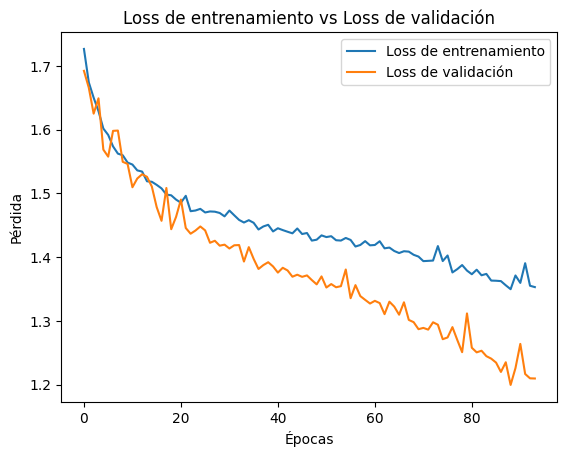

In [100]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Cargar el archivo CSV
dataset = pd.read_csv('/kaggle/input/emotion-recognition-dataset/data.csv')

# Verifica que el archivo se haya cargado correctamente
print(dataset.head())

# Convertir etiquetas a categorías
sentimientos = dataset['label'].astype('category').cat.codes
labels = to_categorical(sentimientos)

images = np.load('/kaggle/input/imagenes/imagenes_procesadas32.npy')
labels = np.array(labels)

# Dividir en datos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# Configuración de Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalización de las imágenes
    rotation_range=30,  # Rotación aleatoria de hasta 30 grados
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    shear_range=0.2,  # Cizallamiento
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal aleatorio
    fill_mode='nearest'  # Rellenar los píxeles faltantes
)

# El generador para validación no necesita augmentación, solo normalización
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Fit el generador de datos de entrenamiento
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
val_generator = val_datagen.flow(x_val, y_val, batch_size=64)

model = Sequential([
    Input(shape=(32, 32, 3)),  # Capa de entrada explícita
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(labels.shape[1], activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar el EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitorea la pérdida en los datos de validación
                               patience=5,          # Número de épocas sin mejora antes de detener el entrenamiento
                               verbose=1,           # Muestra información sobre el early stopping
                               restore_best_weights=True)  # Restaura los pesos del modelo cuando se detiene

# Entrenar el modelo con EarlyStopping
history = model.fit(x_train, y_train, 
                    batch_size=64, 
                    epochs=100, 
                    validation_data=(x_val, y_val), 
                    verbose=1,
                    callbacks=[early_stopping])

# Evaluar el modelo en los datos de validación
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Pérdida en los datos de validación: {loss}')
print(f'Precisión en los datos de validación: {accuracy}')

# Realizar predicciones sobre los datos de validación
y_pred = model.predict(x_val)

# Convertir las predicciones a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calcular el F1 score
f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')  # 'weighted' para ponderar por el tamaño de cada clase
print(f'F1 Score: {f1}')

# Graficar las pérdidas de entrenamiento y validación
plt.plot(history.history['loss'], label='Loss de entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de validación')

# Agregar etiquetas y título
plt.title('Loss de entrenamiento vs Loss de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar el gráfico
plt.show()

##Explicaciones

Se puede observar que a medida que se aumenta la resolucion de la imagen, lso resultados van mejorando, en todas las pruebas no se pudo superar el 75% de acuracy, sin embargo, analizando el dataset, hay errores en cuanto a algunas imagenes estando erroneamente clasificadas. Al mismo tiempo podemos observar como a medida que se esta yendo mas profundo en el modelo, el que se vaya dropeando mas neuronas en las capas mas profundas, el modelo demuestra un mejor comportamiento, al igual que el disminuir las neuronas en las capas mas superficiales ayuda a un buen desempeño del modelo, ambas cosas tienen sentido, en el contexto de que las capas mas profundas tienen la tarea de detectar caracteristicas complejas de las imagenes, a diferencia de las priemras capas.

In [ ]:
!pip install keras-tuner

In [124]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import kerastuner as kt

# Función para crear el modelo
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(32, 32, 3)))  # Capa de entrada explícita
    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(Conv2D(filters=hp.Choice('filters_' + str(i), values=[16, 32, 64]),
                         kernel_size=hp.Choice('kernel_size_' + str(i), values=[3, 5]),
                         activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Flatten())
    model.add(Dense(units=hp.Choice('dense_units', values=[32, 64, 128]), activation='relu'))
    model.add(Dropout(rate=hp.Float('dense_dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=labels.shape[1], activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Cargar el archivo CSV
dataset = pd.read_csv('/kaggle/input/emotion-recognition-dataset/data.csv')

# Convertir etiquetas a categorías
sentimientos = dataset['label'].astype('category').cat.codes
labels = to_categorical(sentimientos)

images = np.load('/kaggle/input/imagenes/imagenes_procesadas32.npy')
labels = np.array(labels)

# Dividir en datos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# Configuración de Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalización de las imágenes
    rotation_range=30,  # Rotación aleatoria de hasta 30 grados
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    shear_range=0.2,  # Cizallamiento
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal aleatorio
    fill_mode='nearest'  # Rellenar los píxeles faltantes
)

# El generador para validación no necesita augmentación, solo normalización
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Fit el generador de datos de entrenamiento
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
val_generator = val_datagen.flow(x_val, y_val, batch_size=64)

# Crear el tuner para la búsqueda de hiperparámetros
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='my_dir',
                     project_name='emotion_recognition')

# Configurar el EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Realizar la búsqueda de hiperparámetros
tuner.search(train_generator, epochs=50, validation_data=val_generator, callbacks=[early_stopping])

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construir y entrenar el mejor modelo
best_model = build_model(best_hps)
history = best_model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[early_stopping])

# Evaluar el mejor modelo encontrado
loss, accuracy = best_model.evaluate(x_val, y_val)
print(f'Pérdida en los datos de validación: {loss}')
print(f'Precisión en los datos de validación: {accuracy}')

# Realizar predicciones sobre los datos de validación
y_pred = best_model.predict(x_val)

# Convertir las predicciones a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calcular el F1 score
f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')
print(f'F1 Score: {f1}')

# Graficar las pérdidas de entrenamiento y validación
plt.plot(history.history['loss'], label='Loss de entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de validación')

# Agregar etiquetas y título
plt.title('Loss de entrenamiento vs Loss de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar el gráfico
plt.show()


Trial 64 Complete [00h 00m 46s]
val_accuracy: 0.3119068145751953

Best val_accuracy So Far: 0.38071614503860474
Total elapsed time: 00h 41m 32s

Search: Running Trial #65

Value             |Best Value So Far |Hyperparameter
2                 |2                 |conv_layers
64                |64                |filters_0
3                 |5                 |kernel_size_0
0.2               |0.4               |dropout_0
64                |64                |dense_units
0.4               |0.3               |dense_dropout
64                |32                |filters_1
5                 |5                 |kernel_size_1
0.4               |0.2               |dropout_1
16                |16                |filters_2
5                 |3                 |kernel_size_2
0.4               |0.4               |dropout_2
4                 |30                |tuner/epochs
0                 |10                |tuner/initial_epoch
2                 |3                 |tuner/bracket
0                 

KeyboardInterrupt: 